In [179]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
from sklearn import preprocessing
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.neighbors import BallTree

In [3]:
import lib

In [4]:
rng = np.random.default_rng(0)

In [5]:
shear_step_plus = "g1_slice=0.02__g2_slice=0.00__g1_other=0.00__g2_other=0.00__zlow=0.0__zhigh=6.0"
shear_step_minus = "g1_slice=-0.02__g2_slice=0.00__g1_other=0.00__g2_other=0.00__zlow=0.0__zhigh=6.0"

In [6]:
shear_sim_plus = h5py.File(
    lib.const.SIM_SHEAR_CATALOGS[shear_step_plus],
)
redshift_sim_plus = h5py.File(
    lib.const.SIM_REDSHIFT_CATALOGS[shear_step_plus],
)

In [7]:
shear_sim_minus = h5py.File(
    lib.const.SIM_SHEAR_CATALOGS[shear_step_minus],
)
redshift_sim_minus = h5py.File(
    lib.const.SIM_REDSHIFT_CATALOGS[shear_step_minus],
)

In [8]:
bhat_sim_plus = lib.tomography.get_tomography(shear_sim_plus, redshift_sim_plus, "noshear")
cell_sim_plus = lib.tomography.get_assignment(shear_sim_plus, redshift_sim_plus, "noshear")
weight_sim_plus = lib.weight.get_shear_weights(shear_sim_plus["mdet/noshear"])

In [9]:
bhat_sim_minus = lib.tomography.get_tomography(shear_sim_minus, redshift_sim_minus, "noshear")
cell_sim_minus = lib.tomography.get_assignment(shear_sim_minus, redshift_sim_minus, "noshear")
weight_sim_minus = lib.weight.get_shear_weights(shear_sim_minus["mdet/noshear"])

In [10]:
shear_y6 = h5py.File(lib.const.Y6_SHEAR_CATALOG)
redshift_y6 = h5py.File(lib.const.Y6_REDSHIFT_CATALOG)

In [11]:
bhat_y6 = lib.tomography.get_tomography(shear_y6, redshift_y6, "noshear")
cell_y6 = lib.tomography.get_assignment(shear_y6, redshift_y6, "noshear")
weight_y6 = lib.weight.get_shear_weights(shear_y6["mdet/noshear"])

In [12]:
# cell_assignments = {}
# for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
#     cell_assignments[tomographic_bin] = np.unique(
#         cell_y6[bhat_y6 == tomographic_bin]
#     ).astype(int)

# assert len(
#     functools.reduce(
#         np.intersect1d,
#         [
#             cells
#             for cells in cell_assignments.values()
#         ],
#     )
# ) == 0
cell_assignments = lib.const.CELL_ASSIGNMENTS

---

In [13]:
sel_sim_plus = np.isin(
    cell_sim_plus,
    cell_assignments[0],
)

In [14]:
sel_sim_minus = np.isin(
    cell_sim_minus,
    cell_assignments[0],
)

In [15]:
sel_y6 = np.isin(
    cell_y6,
    cell_assignments[0],
)

In [16]:
_weight_sim_plus = weight_sim_plus[sel_sim_plus]

In [17]:
_weight_sim_minus = weight_sim_minus[sel_sim_minus]

In [67]:
_weight_y6 = weight_y6[sel_y6]

In [18]:
_mag_sim_plus = lib.util.flux_to_mag(
    np.mean(
        [
            shear_sim_plus["mdet/noshear"]["pgauss_band_flux_r"][sel_sim_plus],
            shear_sim_plus["mdet/noshear"]["pgauss_band_flux_i"][sel_sim_plus],
            shear_sim_plus["mdet/noshear"]["pgauss_band_flux_z"][sel_sim_plus],
        ],
        axis=0,
    )
)

In [19]:
_mag_sim_minus = lib.util.flux_to_mag(
    np.mean(
        [
            shear_sim_minus["mdet/noshear"]["pgauss_band_flux_r"][sel_sim_minus],
            shear_sim_minus["mdet/noshear"]["pgauss_band_flux_i"][sel_sim_minus],
            shear_sim_minus["mdet/noshear"]["pgauss_band_flux_z"][sel_sim_minus],
        ],
        axis=0,
    )
)

In [20]:
_points_sim_plus = np.deg2rad(
    np.stack(
        [shear_sim_plus["mdet/noshear"]["ra"][sel_sim_plus], shear_sim_plus["mdet/noshear"]["dec"][sel_sim_plus]],
        axis=-1,
    )
)

In [21]:
_points_sim_minus = np.deg2rad(
    np.stack(
        [shear_sim_minus["mdet/noshear"]["ra"][sel_sim_minus], shear_sim_minus["mdet/noshear"]["dec"][sel_sim_minus]],
        axis=-1,
    )
)

In [22]:
_mag_y6 = lib.util.flux_to_mag(
    np.mean(
        [
            shear_y6["mdet/noshear"]["pgauss_band_flux_r"][sel_y6],
            shear_y6["mdet/noshear"]["pgauss_band_flux_i"][sel_y6],
            shear_y6["mdet/noshear"]["pgauss_band_flux_z"][sel_y6],
        ],
        axis=0,
    )
)

In [23]:
_points_y6 = np.deg2rad(
    np.stack(
        [shear_y6["mdet/noshear"]["ra"][sel_y6], shear_y6["mdet/noshear"]["dec"][sel_y6]],
        axis=-1
    )
)

In [24]:
bt_sim_plus = BallTree(
    _points_sim_plus,
    metric="haversine",
)

In [25]:
bt_sim_minus = BallTree(
    _points_sim_minus,
    metric="haversine",
)

In [26]:
bt_y6 = BallTree(
    _points_y6,
    metric="haversine",
)

In [123]:
N_SUBSAMPLE = 400_000

In [141]:
_sim_subsample_plus = rng.choice(sum(sel_sim_plus), N_SUBSAMPLE, replace=False)
sim_subsample_plus = np.isin(
    np.arange(sum(sel_sim_plus)),
    _sim_subsample_plus,
)

In [142]:
_sim_subsample_minus = rng.choice(sum(sel_sim_minus), N_SUBSAMPLE, replace=False)
sim_subsample_minus = np.isin(
    np.arange(sum(sel_sim_minus)),
    _sim_subsample_minus,
)

In [104]:
_y6_subsample = rng.choice(sum(sel_y6), N_SUBSAMPLE, replace=False)
y6_subsample = np.isin(
    np.arange(sum(sel_y6)),
    _y6_subsample,
)

2790088

In [143]:
dist_sim_plus, ind_sim_plus = bt_sim_plus.query(
    _points_sim_plus[sim_subsample_plus],
    k=2,
    return_distance=True,  # default, but we depend on this behavior
    sort_results=True,  # default, but we depend on this behavior
)

In [144]:
dist_sim_minus, ind_sim_minus = bt_sim_minus.query(
    _points_sim_minus[sim_subsample_minus],
    k=2,
    return_distance=True,  # default, but we depend on this behavior
    sort_results=True,  # default, but we depend on this behavior
)

In [64]:
dist_y6, ind_y6 = bt_y6.query(
    _points_y6[y6_subsample],
    k=2,
    return_distance=True,  # default, but we depend on this behavior
    sort_results=True,  # default, but we depend on this behavior
)

In [145]:
neighbor_distance_sim_plus = dist_sim_plus[:, 1]
source_magnitude_sim_plus = _mag_sim_plus[ind_sim_plus[:, 0]]
neighbor_magnitude_sim_plus = _mag_sim_plus[ind_sim_plus[:, 1]]
weight_sim_plus = _weight_sim_plus[ind_sim_plus[:, 0]]

In [146]:
neighbor_distance_sim_minus = dist_sim_minus[:, 1]
source_magnitude_sim_minus = _mag_sim_minus[ind_sim_minus[:, 0]]
neighbor_magnitude_sim_minus = _mag_sim_minus[ind_sim_minus[:, 1]]
weight_sim_minus = _weight_sim_minus[ind_sim_minus[:, 0]]

In [68]:
# neighbor_distance_y6 = distances_y6[:, 1] * 60 * 60
neighbor_distance_y6 = dist_y6[:, 1]
source_magnitude_y6 = _mag_y6[ind_y6[:, 0]]
neighbor_magnitude_y6 = _mag_y6[ind_y6[:, 1]]
weight_y6 = _weight_y6[ind_y6[:, 0]]

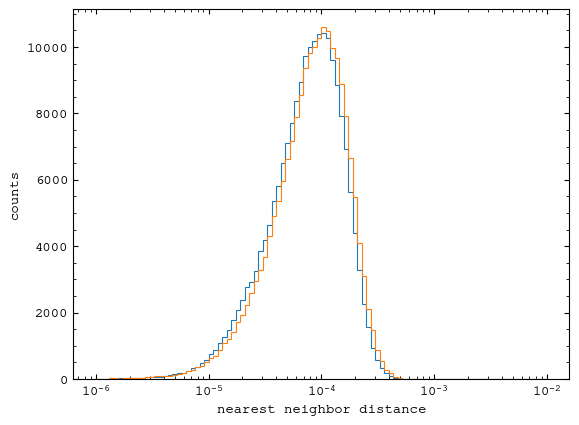

In [35]:
# bins = np.geomspace(1e0, 1e2, 101)
NBINS = 100
bins = np.geomspace(1e-6, 1e-2, NBINS + 1)

fig, axs = plt.subplots(1, 1)

axs.hist(neighbor_distance_y6, bins=bins, histtype="step")
axs.hist(
    np.concatenate([neighbor_distance_sim_plus, neighbor_distance_sim_minus]),
    bins=bins,
    histtype="step",
)


axs.set_xscale("log")

axs.set_xlabel("nearest neighbor distance")
axs.set_ylabel("counts")

fig.show()

In [147]:
X_sim = np.concatenate(
    [
        np.stack([np.log10(neighbor_distance_sim_plus), source_magnitude_sim_plus, neighbor_magnitude_sim_plus], axis=-1),
        np.stack([np.log10(neighbor_distance_sim_minus), source_magnitude_sim_minus, neighbor_magnitude_sim_minus], axis=-1),
    ],
)
W_sim = np.concatenate(
    [weight_sim_plus, weight_sim_minus],
)
X_y6 = np.stack([np.log10(neighbor_distance_y6), source_magnitude_y6, neighbor_magnitude_y6], axis=-1)
W_y6 = weight_y6

In [148]:
X = np.concatenate([X_sim, X_y6])
W = np.concatenate([W_sim, W_y6])

In [149]:
scaler = preprocessing.StandardScaler().fit(X)

In [181]:
ns = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]
inertias = []
inertias_batch = []
for n in ns:
    kmeans = KMeans(
        n_clusters=n,
        random_state=0,
    ).fit(
        scaler.transform(X),
        sample_weight=W,
    )
    inertias.append(kmeans.inertia_)

    batch_kmeans = MiniBatchKMeans(
        n_clusters=n,
        random_state=0,
    ).fit(
        scaler.transform(X),
        sample_weight=W,
    )
    inertias_batch.append(batch_kmeans.inertia_)

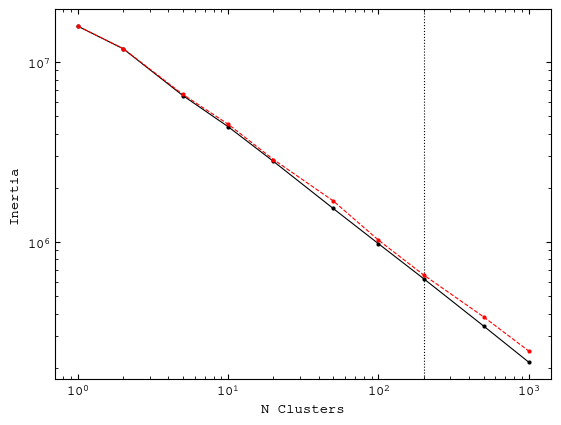

In [185]:
plt.axvline(200, ls=":")
plt.plot(
    ns,
    inertias,
    marker="o",
    markersize=2,
    c="k",
)
plt.plot(
    ns,
    inertias_batch,
    marker="o",
    markersize=2,
    c="r",
    ls="--",
)
plt.xlabel("N Clusters")
plt.ylabel("Inertia")
plt.loglog()
plt.show()

In [75]:
N_CLUSTERS = 200

In [150]:
kmeans = KMeans(
    n_clusters=N_CLUSTERS,
    random_state=0,
).fit(
    scaler.transform(X),
    sample_weight=W,
)

In [151]:
# y_sim = kmeans.predict(scaler.transform(X_sim))

X_sim_plus = np.stack([np.log10(neighbor_distance_sim_plus), source_magnitude_sim_plus, neighbor_magnitude_sim_plus], axis=-1)
y_sim_plus = kmeans.predict(scaler.transform(X_sim_plus))

X_sim_minus = np.stack([np.log10(neighbor_distance_sim_minus), source_magnitude_sim_minus, neighbor_magnitude_sim_minus], axis=-1)
y_sim_minus = kmeans.predict(scaler.transform(X_sim_minus))

In [152]:
y_y6 = kmeans.predict(scaler.transform(X_y6))

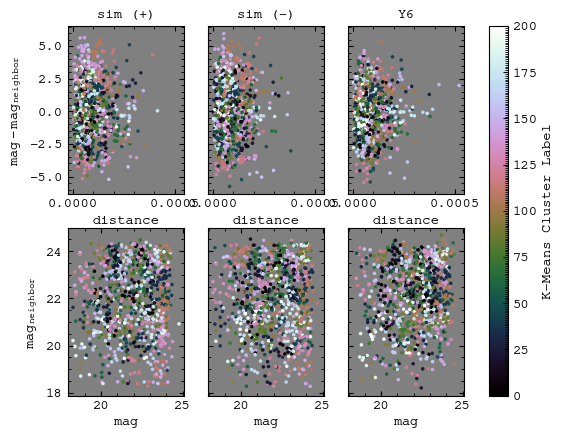

In [153]:
cmap = mpl.cm.cubehelix
bounds = np.unique(kmeans.labels_)
bounds = np.append(bounds, bounds[-1] + 1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

N_SUBSAMPLE = 1_000
_sim_subsample_plus = rng.choice(len(X_sim_plus), N_SUBSAMPLE, replace=False)
_sim_subsample_minus = rng.choice(len(X_sim_minus), N_SUBSAMPLE, replace=False)

_y6_subsample = rng.choice(len(X_y6), N_SUBSAMPLE, replace=False)

fig, axs = plt.subplots(2, 3, sharex="row", sharey="row")

for ax in axs.ravel():
    ax.set_facecolor("grey")

axs[0, 0].scatter(
    10**X_sim_plus[_sim_subsample_plus, 0],
    X_sim_plus[_sim_subsample_plus, 1] - X_sim_plus[_sim_subsample_plus, 2],
    c=y_sim_plus[_sim_subsample_plus],
    cmap=cmap,
    norm=norm,
    s=12,
)
axs[0, 0].set_xlabel("distance")
axs[0, 0].set_ylabel("$mag - mag_{neighbor}$")

axs[0, 1].scatter(
    10**X_sim_minus[_sim_subsample_minus, 0],
    X_sim_minus[_sim_subsample_minus, 1] - X_sim_minus[_sim_subsample_minus, 2],
    c=y_sim_minus[_sim_subsample_minus],
    cmap=cmap,
    norm=norm,
    s=12,
)
axs[0, 1].set_xlabel("distance")
# axs[0, 1].set_ylabel("$mag - mag_{neighbor}$")

axs[0, 2].scatter(
    10**X_y6[_y6_subsample, 0],
    X_y6[_y6_subsample, 1] - X_y6[_y6_subsample, 2],
    c=y_y6[_y6_subsample],
    cmap=cmap,
    norm=norm,
    s=12,
)
axs[0, 2].set_xlabel("distance")
# axs[0, 2].set_ylabel("$mag - mag_{neighbor}$")

axs[1, 0].scatter(
    X_sim_plus[_sim_subsample_plus, 1],
    X_sim_plus[_sim_subsample_plus, 2],
    c=y_sim_plus[_sim_subsample_plus],
    cmap=cmap,
    norm=norm,
    s=12,
)
axs[1, 0].set_xlabel("$mag$")
axs[1, 0].set_ylabel("$mag_{neighbor}$")

axs[1, 1].scatter(
    X_sim_minus[_sim_subsample_minus, 1],
    X_sim_minus[_sim_subsample_minus, 2],
    c=y_sim_minus[_sim_subsample_minus],
    cmap=cmap,
    norm=norm,
    s=12,
)
axs[1, 1].set_xlabel("$mag$")
# axs[1, 1].set_ylabel("$mag_{neighbor}$")

axs[1, 2].scatter(
    X_y6[_y6_subsample, 1],
    X_y6[_y6_subsample, 2],
    c=y_y6[_y6_subsample],
    cmap=cmap,
    norm=norm,
    s=12,
)
axs[1, 2].set_xlabel("$mag$")
# axs[1, 2].set_ylabel("$mag_{neighbor}$")

axs[0, 0].set_title("sim (+)")
axs[0, 1].set_title("sim (-)")
axs[0, 2].set_title("Y6")

# fig.supxlabel("nearest neighbor distance [arcsec]")
# fig.supylabel("$mag - mag_{neighbor}$")

cb = fig.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=axs.ravel(),
    label="K-Means Cluster Label",
    spacing="proportional",
)
cb.locator = mpl.ticker.MaxNLocator(nbins="auto", integer=True)
cb.minor_locator = mpl.ticker.NullLocator()

plt.show()

---

In [154]:
w_bins = np.arange(N_CLUSTERS)

In [175]:
w_plus = np.bincount(y_y6) / np.bincount(y_sim_plus)
w_plus = np.ma.masked_invalid(w_plus)
w_plus /= np.mean(w_plus)

# # fix bins that don't have assignments
# ww[ww==0.] = 1.
# ww[ww>5.] = 5.

/tmp/ipykernel_349116/3166568794.py:1: RuntimeWarning: divide by zero encountered in divide
  w_plus = np.bincount(y_y6) / np.bincount(y_sim_plus)


In [177]:
w_minus = np.bincount(y_y6) / np.bincount(y_sim_minus)
w_minus = np.ma.masked_invalid(w_minus)
w_minus /= np.nanmean(w_minus)

/tmp/ipykernel_349116/311727882.py:1: RuntimeWarning: divide by zero encountered in divide
  w_minus = np.bincount(y_y6) / np.bincount(y_sim_minus)


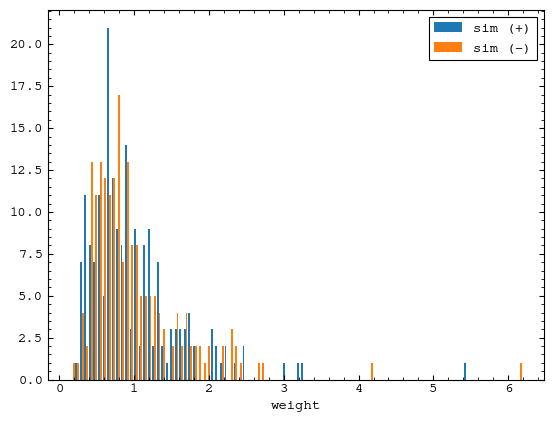

In [178]:
plt.hist(
    [w_plus, w_minus],
    label=["sim (+)", "sim (-)"],
    bins=100,
)
plt.xlabel("weight")
plt.legend()
plt.show()

In [50]:
y_sim_plus.shape, sel_sim_plus.shape, ind_sim_plus.shape

((100000,), (13330748,), (100000, 2))

In [192]:
tmp = np.full(shear_sim_plus["mdet/noshear"]["uid"].shape, np.nan)

_ind = np.digitize(
    y_sim_plus,
    w_bins,
    right=True,
)

tmp[ind_sim_plus[:, 0]][_ind] = w_plus[_ind]

In [194]:
_ind.shape

(1000,)